# Part 1: Data Setup

In [1]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/03 02:51:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!wget https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
!wget https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip
!wget https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip

--2023-04-03 02:51:39--  https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21494278 (20M) [application/zip]
Saving to: ‘hdma-wi-2021.zip’

hdma-wi-2021.zip    100%[===================>]  20.50M  10.5MB/s    in 1.9s    

2023-04-03 02:51:41 (10.5 MB/s) - ‘hdma-wi-2021.zip’ saved [21494278/21494278]

--2023-04-03 02:51:42--  https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 798030 (779K) [application/zip]
Saving to: ‘code_sheets.zip’

code_sheets.zip     100%[===================>] 779.33K  --.-KB/s    in 0.1s    

2023-04-03 02:51:42 (5.08 MB/s) - ‘code_sheets.zip’ saved

In [3]:
import zipfile

# Unzip files 
with zipfile.ZipFile('hdma-wi-2021.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
    
with zipfile.ZipFile('code_sheets.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

with zipfile.ZipFile('arid2017_to_lei_xref_csv.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [4]:
import os

# Get list of csv files in directory
csv_files = [f for f in os.listdir() if f.endswith('.csv')]

# Copy files to HDFS
for file in csv_files:
    path = f"hdfs://main:9000/{file}"
    !hdfs dfs -cp {file} {path}

cp: `hdfs://main:9000/tracts.csv': File exists
cp: `hdfs://main:9000/edit_status.csv': File exists
cp: `hdfs://main:9000/loan_type.csv': File exists
cp: `hdfs://main:9000/counties.csv': File exists
cp: `hdfs://main:9000/purchaser_type.csv': File exists
cp: `hdfs://main:9000/lien_status.csv': File exists
cp: `hdfs://main:9000/hoepa.csv': File exists
cp: `hdfs://main:9000/hdma-wi-2021.csv': File exists
cp: `hdfs://main:9000/agency.csv': File exists
cp: `hdfs://main:9000/denial_reason.csv': File exists
cp: `hdfs://main:9000/states.csv': File exists
cp: `hdfs://main:9000/owner_occupancy.csv': File exists
cp: `hdfs://main:9000/msamd.csv': File exists
cp: `hdfs://main:9000/race.csv': File exists
cp: `hdfs://main:9000/ethnicity.csv': File exists
cp: `hdfs://main:9000/sex.csv': File exists
cp: `hdfs://main:9000/loan_purpose.csv': File exists
cp: `hdfs://main:9000/preapproval.csv': File exists
cp: `hdfs://main:9000/arid2017_to_lei_xref_csv.csv': File exists
cp: `hdfs://main:9000/property_type.c

In [5]:
# Load hdma-wi-2021.csv to loans table
loans = (spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load("hdfs://main:9000/hdma-wi-2021.csv"))

# Divide loans table into 8 buckets 
loans = loans.repartition(8, "county_code")

# Load arid2017_to_lei_xref.csv to banks table
banks = (spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("hdfs://main:9000/arid2017_to_lei_xref_csv.csv"))

# Load CSV files from code_sheets.zip and create temporary views
csv_files = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken", "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]
csv_dfs = {}

# Populate "csv_dfs" dictionary with data
for csv_file in csv_files:
    csv_df = (spark.read.format("csv")
        .option("header", "true")
        .option("inferSchema", "true")
        .load(f"hdfs://main:9000/{csv_file}.csv"))
    csv_dfs[csv_file] = csv_df

for csv_file, csv_df in csv_dfs.items():
    csv_df.createOrReplaceTempView(csv_file)


loans.write.format("parquet").mode("overwrite").saveAsTable("loans")
banks.write.format("parquet").mode("overwrite").saveAsTable("banks")

23/04/03 02:53:20 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/04/03 02:53:20 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/04/03 02:53:25 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/04/03 02:53:25 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.21.0.4
23/04/03 02:53:26 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/04/03 02:53:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/04/03 02:53:56 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/04/03 02:53:56 WARN HiveConf: HiveCon

### Q1: What tables are in our warehouse?

In [6]:
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



# Part 2: Filter and Join

### Q2: How many banks contain the word "first" in their name? Which ones contain "second"?

In [7]:
# Contain "first" in their name
first_banks = banks.filter("lower(respondent_name) like '%first%'")
num_first_banks = first_banks.count()

# Contain "second" in their name
second_banks = banks.filter("lower(respondent_name) like '%second%'")
list_second_banks = list(second_banks.toPandas().respondent_name)
print("Number of banks containing 'first' in their name:", num_first_banks)
print("List of banks containing 'second' in their name:", list_second_banks)
      

Number of banks containing 'first' in their name: 525
List of banks containing 'second' in their name: ['Old Second National Bank']


### Q3: how many loan applications has your "favorite" bank received in the dataset?


In [8]:
favorite_bank = "Wells Fargo Bank, National Association"

# join loans and banks tables
joined_df = spark.table("loans").join(spark.table("banks"), spark.table("loans").lei == spark.table("banks").lei_2020)

# Get df with favorite bank
filtered_df = joined_df.filter(spark.table("banks").respondent_name == favorite_bank)

# count the number of loan applications received by Wells Fargo
count = filtered_df.count()

print(f"{count} loan applications")

12487 loan applications


### Q4: what does results.explain("formatted") tell us about Spark's query plan for Q3?

In [9]:
filtered_df.explain("formatted")
# The "banks" table is being sent to every executer 
# "is not null" filtering is on both tables
# There is no HashAggregate plan

== Physical Plan ==
AdaptiveSparkPlan (7)
+- BroadcastHashJoin Inner BuildRight (6)
   :- Filter (2)
   :  +- Scan parquet default.loans (1)
   +- BroadcastExchange (5)
      +- Filter (4)
         +- Scan parquet default.banks (3)


(1) Scan parquet default.loans
Output [99]: [activity_year#963, lei#964, derived_msa-md#965, state_code#966, county_code#967, census_tract#968, conforming_loan_limit#969, derived_loan_product_type#970, derived_dwelling_category#971, derived_ethnicity#972, derived_race#973, derived_sex#974, action_taken#975, purchaser_type#976, preapproval#977, loan_type#978, loan_purpose#979, lien_status#980, reverse_mortgage#981, open-end_line_of_credit#982, business_or_commercial_purpose#983, loan_amount#984, loan_to_value_ratio#985, interest_rate#986, rate_spread#987, hoepa_status#988, total_loan_costs#989, total_points_and_fees#990, origination_charges#991, discount_points#992, lender_credits#993, loan_term#994, prepayment_penalty_term#995, intro_rate_period#996, negat

### Q5: what are the top 10 biggest loans (in terms of loan_amount) that were approved by your favorite bank?

In [10]:
from pyspark.sql.functions import *

# Get relevant data from dictionary
loan_purpose = csv_dfs["loan_purpose"]
counties = csv_dfs["counties"]
action_taken = csv_dfs["action_taken"]


# Make table with matching county code to "loans" table
counties_with_code = counties.withColumn(
    "state_county_code",
    concat(lpad(counties.STATE.cast("string"), 2, "0"), lpad(counties.COUNTY.cast("string"), 3, "0"))
)

# Join to get loans table with county name
loans_with_county_name = loans.join(
    counties_with_code, 
    loans.county_code == counties_with_code.state_county_code, 
    "left_outer"
)

# Join with banks table
loans_banks = loans_with_county_name.join(
    banks,
    loans_with_county_name.lei == banks.lei_2020,
    "left_outer"
)

# Filter for favorite bank
fav_df = loans_banks.filter(loans_banks.respondent_name == favorite_bank)

# Change column name for easier join process
fav_df = fav_df.withColumnRenamed("loan_purpose", "lp")

# Join with loan_purpose table
fav_df = loan_purpose.join(
    fav_df,
    fav_df.lp == loan_purpose.id,
    "left_outer"
)

# Get "thousands" column
fav_df = fav_df.withColumn("thousands", col("loan_amount") / 1000)

# Change column name for easier join process
fav_df = fav_df.withColumnRenamed("action_taken", "at")

# Join to get "action_taken" column
fav_df = action_taken.join(
    fav_df,
    fav_df.at == action_taken.id,
    "left_outer"
)

# Filter to get top 10 valid loans
fav_df_10 = fav_df.filter(fav_df.action_taken == "Loan originated") \
                   .sort(desc("loan_amount")) \
                   .limit(10)

# Renaming to fit requirements 
fav_df_10 = fav_df_10.withColumnRenamed("county", "c")
fav_df_10 = fav_df_10.withColumnRenamed("NAME", "county")

# Months to years transformation with "loan_term"
fav_df_10 = fav_df_10.withColumn("years", col("loan_term") / 12)

# Select relevant columns
fav_df_10 = fav_df_10.select("census_tract", "county", "loan_purpose", "derived_dwelling_category", "thousands", "interest_rate", "years", "action_taken")

fav_df_10.toPandas()

,census_tract,county,loan_purpose,derived_dwelling_category,thousands,interest_rate,years,action_taken
0,55127000302,Walworth,Home purchase,Single Family (1-4 Units):Site-Built,1545.0,1.875,30.0,Loan originated
1,55079080300,Milwaukee,Home purchase,Single Family (1-4 Units):Site-Built,1305.0,2.25,30.0,Loan originated
2,55079014300,Milwaukee,Home purchase,Single Family (1-4 Units):Site-Built,1245.0,2.875,30.0,Loan originated
3,55089660202,Ozaukee,Home purchase,Single Family (1-4 Units):Site-Built,1205.0,3.0,30.0,Loan originated
4,55079018200,Milwaukee,Home purchase,Single Family (1-4 Units):Site-Built,1195.0,2.375,30.0,Loan originated
5,55125950600,Vilas,Home purchase,Single Family (1-4 Units):Site-Built,1125.0,2.625,30.0,Loan originated
6,55133203802,Waukesha,Home purchase,Single Family (1-4 Units):Site-Built,1005.0,1.375,30.0,Loan originated
7,55059003001,Kenosha,Home purchase,Single Family (1-4 Units):Site-Built,1005.0,3.125,15.0,Loan originated
8,55133204400,Waukesha,Home purchase,Single Family (1-4 Units):Site-Built,915.0,2.875,30.0,Loan originated
9,55095960900,Polk,Home purchase,Single Family (1-4 Units):Site-Built,905.0,2.5,30.0,Loan originated


# Part 3: GROUPY BY and Windowing

### Q6: when computing a MEAN aggregate per group of loans, under what situation (when) do we require network I/O between the partial_mean and mean operations?


In [11]:
spark.sql("SELECT county_code, AVG(loan_amount) FROM loans GROUP BY county_code").explain()
spark.sql("SELECT lei, AVG(loan_amount) FROM loans GROUP BY lei").explain()


# In both queries network I/O is required between the operations.
# This is because the data must be shuffled across nodes.
# Network I/O is required in these cases where partial mean is computed on different nodes.

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#967], functions=[avg(loan_amount#984)])
   +- Exchange hashpartitioning(county_code#967, 200), ENSURE_REQUIREMENTS, [plan_id=1117]
      +- HashAggregate(keys=[county_code#967], functions=[partial_avg(loan_amount#984)])
         +- FileScan parquet default.loans[county_code#967,loan_amount#984] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://main:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,loan_amount:double>


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#964], functions=[avg(loan_amount#984)])
   +- Exchange hashpartitioning(lei#964, 200), ENSURE_REQUIREMENTS, [plan_id=1130]
      +- HashAggregate(keys=[lei#964], functions=[partial_avg(loan_amount#984)])
         +- FileScan parquet default.loans[lei#964,loan_amount#984] Batched: true, DataFilters

### Q7: what are the average interest rates for Wells Fargo applications for the ten counties where Wells Fargo receives the most applications?

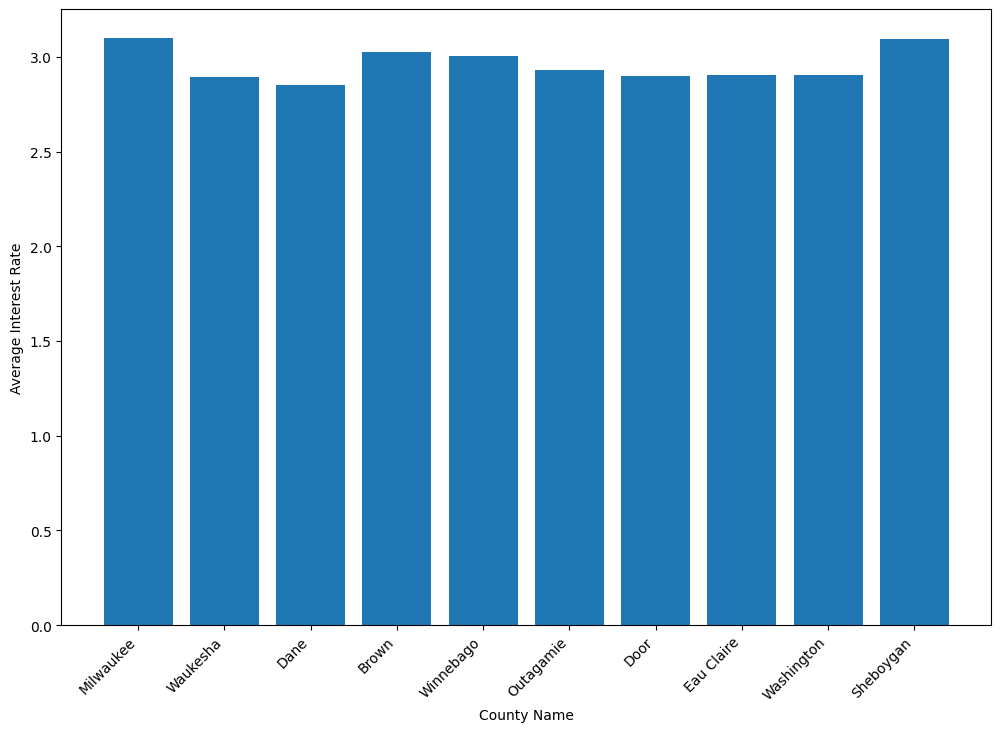

In [12]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import count
import warnings

warnings.filterwarnings("ignore")

county_interest_rates = fav_df.filter(fav_df.action_taken == "Loan originated") \
                              .groupBy("NAME") \
                              .agg(avg("interest_rate").alias("avg_interest_rate"), 
                                   count("*").alias("num_applications")) \
                              .orderBy(desc("num_applications")) \
                              .limit(10)

x = list(county_interest_rates.toPandas().NAME)
y = list(county_interest_rates.toPandas().avg_interest_rate)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x = x, height = y)
ax.set_xlabel("County Name")
ax.set_ylabel("Average Interest Rate")
ax.set_xticklabels(labels = x, rotation = 45, ha = "right")
plt.show()

### Q8: what is the second biggest loan application amount in each county? (answer for top 10 counties).


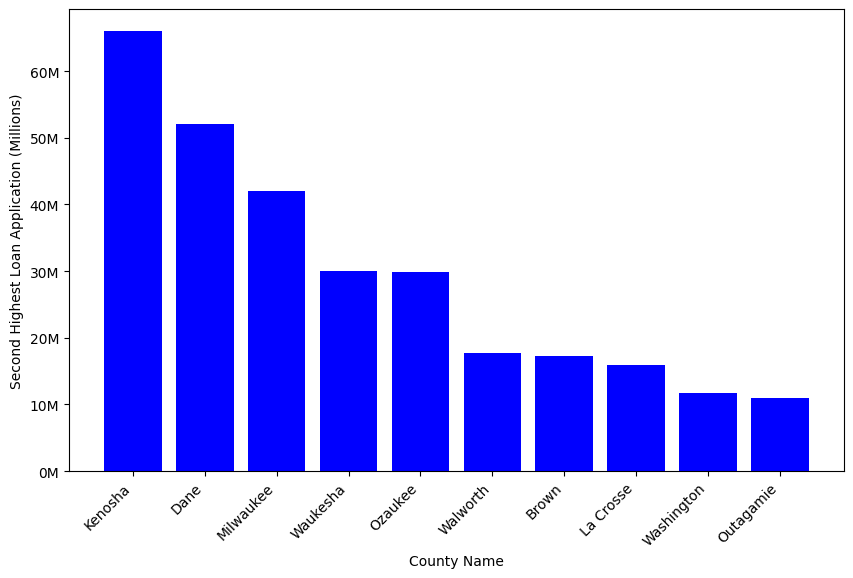

In [13]:
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Get second ranked loans in table
second_ranked_loans = loans_with_county_name.select("NAME", "loan_amount") \
    .groupBy("NAME") \
    .agg(max("loan_amount").alias("max_loan_amount")) \
    .withColumnRenamed("NAME", "county_name") \
    .join(loans_with_county_name.select("county_code", "NAME", "loan_amount").withColumnRenamed("NAME", "county_name"), on="county_name", how="left") \
    .filter(col("loan_amount") < col("max_loan_amount")) \
    .groupBy("county_name") \
    .agg(max("loan_amount").alias("second_highest_loan_amount"))

top_10_counties = second_ranked_loans.orderBy(desc("second_highest_loan_amount")).limit(10).toPandas()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
top_10_counties["second_highest_loan_amount"] = top_10_counties["second_highest_loan_amount"].div(1e6)
ax.bar(x = top_10_counties["county_name"], height = top_10_counties["second_highest_loan_amount"], color="blue")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}M")) # Inspired by https://stackoverflow.com/questions/25119193/matplotlib-pyplot-axes-formatter
ax.set_xticklabels(top_10_counties["county_name"], rotation = 45, ha = "right")
ax.set_xlabel("County Name")
ax.set_ylabel("Second Highest Loan Application (Millions)")
plt.show()

# Part 4: Caching

In [14]:
warnings.filterwarnings("default")
df = banks.join(loans, banks.lei_2020 == loans.lei).select(col("interest_rate")) \
         .filter(col("respondent_name") == "Wells Fargo Bank, National Association")

### Q9: what is the cost of caching and the impact on subsequent queries?


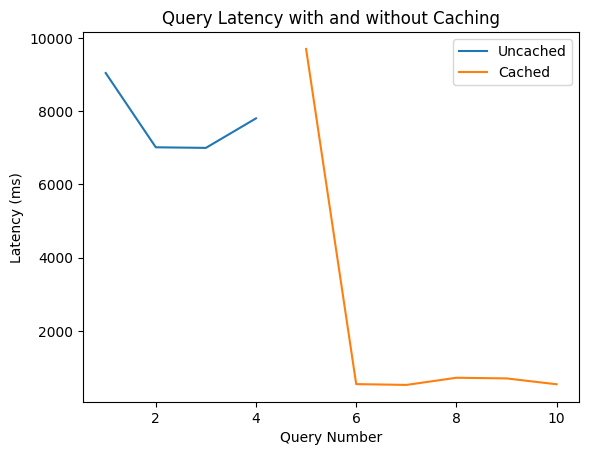

In [15]:
import time

uncached_latency = []
cached_latency = []

# loop over 10 queries
for i in range(1, 11):
    start_time = time.time()
    count = df.count()
    end_time = time.time()
    latency = (end_time - start_time) * 1000
    
    if i < 5:
        uncached_latency.append(latency)
    else:
        cached_latency.append(latency)
        
    # cache df after 4th query
    if i == 4:
        df.cache()

# Plotting
plt.plot(range(1, 5), uncached_latency, label="Uncached")
plt.plot(range(5, 11), cached_latency, label="Cached")
plt.xlabel("Query Number")
plt.ylabel("Latency (ms)")
plt.title("Query Latency with and without Caching")
plt.legend()
plt.show()

### Q10: what is the impact of caching a single partition on load balance?


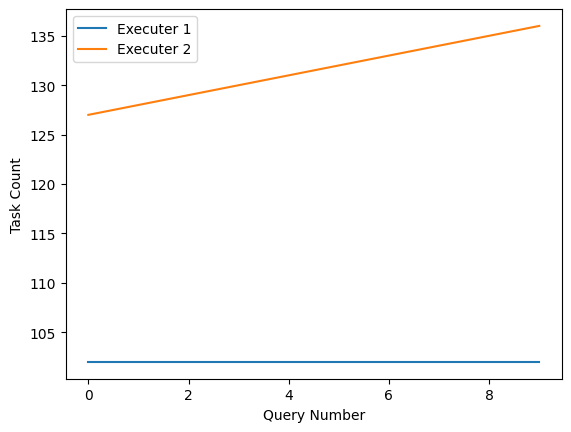

In [17]:
import requests
import json

# Get app id
app_id = requests.get("http://localhost:4040/api/v1/applications").json()[0]['id']

# Give DataFrame 1 partition and cache it
df = df.repartition(1).cache()

# Initialize lists for the task counts
executor1 = []
executor2 = []

# Loop over 10 queries, get counts
for i in range(10):
    count = df.count()
    metrics_url = f"http://localhost:4040/api/v1/applications/{app_id}/executors"
    response = requests.get(metrics_url)
    data = json.loads(response.content.decode('utf-8'))
    for executor in data:
        if executor['id'] == '0':
            executor1.append(executor['completedTasks'])
            
        elif executor['id'] == '1':
            executor2.append(executor['completedTasks'])

# Plotting
fig, ax = plt.subplots()
ax.plot(executor1, label = "Executer 1")
ax.plot(executor2, label = "Executer 2")
ax.legend()
ax.set_xlabel('Query Number')
ax.set_ylabel('Task Count')
plt.show()